In [1]:
import json
import os
import time

import pandas as pd
import networkx as nx

from kafka import KafkaConsumer, KafkaProducer, KafkaAdminClient
import redis

from graph_based_intrusion_detection.utils import constants
from graph_based_intrusion_detection.utils.network_transport_utils import deserialize, serialize

In [2]:
# constants
devices_root = os.path.abspath('../../../')
time_field = 'geninfo/timestamp'
timedelta_field = "timedelta"


In [3]:
# read merged dataset
row_limit = None
idle_dataset_path = os.path.join(devices_root, 'idle_merged.pickle')
activity_dataset_path = os.path.join(devices_root, 'activity_merged.pickle')
attack_dataset_path = os.path.join(devices_root, 'attack_merged.pickle')

idle_dataset = pd.read_pickle(idle_dataset_path)
activity_dataset = pd.read_pickle(activity_dataset_path)
attack_dataset = pd.read_pickle(attack_dataset_path)

merged_dataset_full = pd.concat([idle_dataset, activity_dataset, attack_dataset])
merged_dataset = merged_dataset_full

print(f"Loaded merged dataset with {len(merged_dataset)} packets")
list(sorted(merged_dataset.columns))

Loaded merged dataset with 3194477 packets


['Activity',
 'Attack',
 'Farbeändern',
 'Helligkeitssteuern',
 'Party',
 'Themen Auswahl',
 'Timer Ein/Aus',
 'Weiß/gelb',
 'Zeitschalter',
 'arp/arp.hw.size',
 'arp/arp.hw.type',
 'arp/arp.opcode',
 'arp/arp.proto.size',
 'arp/arp.proto.type',
 'eth/eth.dst',
 'eth/eth.dst/eth.dst.ig',
 'eth/eth.dst/eth.dst.oui',
 'eth/eth.dst/eth.lg',
 'eth/eth.src',
 'eth/eth.src/eth.ig',
 'eth/eth.src/eth.lg',
 'eth/eth.src/eth.src.oui',
 'eth/eth.type',
 'frame/frame.encap_type',
 'frame/frame.len',
 'frame/frame.marked',
 'frame/frame.number',
 'frame/frame.offset_shift',
 'frame/frame.time_delta',
 'frame/frame.time_relative',
 'geninfo/timestamp',
 'icmp/data/data.len',
 'icmp/icmp.checksum.status',
 'icmp/icmp.code',
 'icmp/icmp.ident',
 'icmp/icmp.resp_in',
 'icmp/icmp.resp_to',
 'icmp/icmp.seq',
 'icmp/icmp.seq_le',
 'icmp/icmp.type',
 'igmp/igmp.checksum.status',
 'igmp/igmp.maddr',
 'igmp/igmp.max_resp',
 'igmp/igmp.type',
 'illuminance_level',
 'ip/<>/ip.options.routeralert/ip.opt.ra',
 

In [4]:
merged_dataset["Attack"]

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
           ...  
1002184    False
1002185    False
1002186    False
1002187     True
1002188    False
Name: Attack, Length: 3194477, dtype: object

In [5]:
# create kafka producer
producer = KafkaProducer(bootstrap_servers='localhost:9092')

In [6]:
df_no_attacks = merged_dataset[merged_dataset["Attack"] == 0]
len(df_no_attacks)

1001608

In [7]:
df_with_attacks = merged_dataset[merged_dataset["Attack"] > 0]
len(df_with_attacks)

581

In [19]:
df_to_use

tcp/tcp.flags/tcp.flags.reset  arp/arp.proto.size  \
1                                False                 4.0   
624196                           False                 NaN   
624197                           False                 NaN   
624198                           False                 NaN   
624199                           False                 NaN   
...                                ...                 ...   
1001457                           True                 NaN   
1001458                          False                 4.0   
1001459                          False                 4.0   
1001460                          False                 NaN   
1002187                          False                 NaN   

         tcp/tcp.options/tcp.options.nop  tcp/tcp.checksum.status  \
1                                    NaN                      NaN   
624196                               NaN                      2.0   
624197                               NaN                      2.0   
624198                               NaN                      2.0   
624199                               NaN                      2.0   
...                                  ...                      ...   
1001457                              NaN                      2.0   
1001458                              NaN                      NaN   
1001459                              NaN                      NaN   
1001460                              NaN                      2.0   
1002187                              NaN                      NaN   

         udp/udp.checksum.status  tcp/tcp.nxtseq  \
1                            NaN             NaN   
624196                       NaN           354.0   
624197                       NaN           354.0   
624198                       NaN           353.0   
624199                       NaN           353.0   
...                          ...             ...   
1001457                      NaN             1.0   
1001458                      NaN             NaN   
1001459                      NaN             NaN   
1001460                      NaN          4210.0   
1002187                      NaN             NaN   

         tcp/tcp.options/tcp.options.mss/tcp.options.mss_val  tcp/tcp.hdr_len  \
1                                                      NaN                NaN   
624196                                                 NaN               20.0   
624197                                                 NaN               20.0   
624198                                                 NaN               20.0   
624199                                                 NaN               20.0   
...                                                    ...                ...   
1001457                                                NaN               20.0   
1001458                                                NaN                NaN   
1001459                                                NaN                NaN   
1001460                                                NaN               20.0   
1002187                                                NaN                NaN   

         tcp/tcp.stream       ip/ip.dst  ...  Farbeändern  Helligkeitssteuern  \
1                   NaN             NaN  ...          NaN                 NaN   
624196             42.0   192.168.1.218  ...          NaN                 NaN   
624197             42.0   192.168.1.218  ...          NaN                 NaN   
624198             42.0   192.168.1.218  ...          NaN                 NaN   
624199             42.0   192.168.1.218  ...          NaN                 NaN   
...                 ...             ...  ...          ...                 ...   
1001457          1002.0   192.168.1.229  ...          NaN                 NaN   
1001458             NaN             NaN  ...          NaN                 NaN   
1001459             NaN             NaN  ...          NaN                 NaN   
1001460             0.0  76

In [8]:
# send packets to kafka
offset = 000_000
length = 1_000
batch_size = 1000
# for i in range(0, len(merged_dataset), batch_size):
#     batch = merged_dataset[i:i + batch_size]
#     for index, packet in batch.iterrows():
#         producer.send(constants.PACKET_TOPIC_NAME, value=kafka_utils.serialize(packet))
#         producer.flush()
#     print(f"Sent batch {i} to {i + batch_size}")

df_to_use = df_with_attacks

for index, packet in df_to_use.iloc[offset:offset + length].iterrows():
    producer.send(constants.PACKET_TOPIC_NAME, value=serialize(packet))

In [33]:
# consume packets from kafka
consumer = KafkaConsumer(constants.NODE_ANALYSIS_TOPIC,
                         bootstrap_servers='localhost:9092',
                         auto_offset_reset='earliest')


In [25]:
message = next(consumer)
state = deserialize(message.value)
state

{'node': '192.168.1.201',
 'time': 1708865999.6744654,
 'results': {'incoming_attack_probability': 0}}

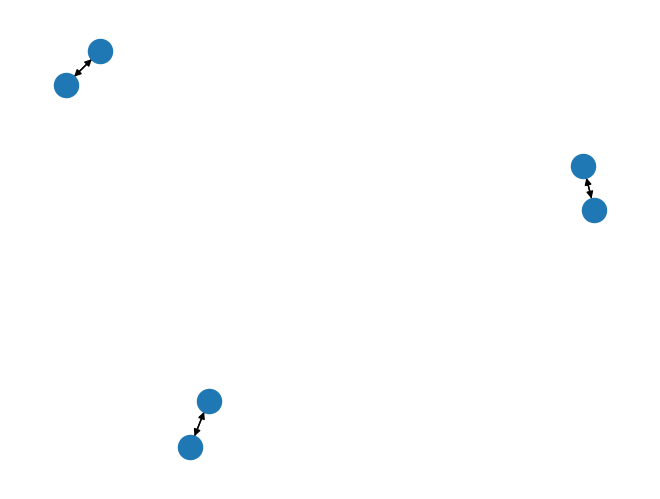

In [23]:
nx.draw(state["layer_3_graph"])

In [35]:
# consume whole topic until empty
counter = 0
for message in consumer:
    counter += 1
    print("Consumed message: ", counter)

KeyboardInterrupt: 

In [50]:
while True:
    for message in consumer:
        packet = json.loads(message.value)
        print("Received packet: ", packet["timedelta"])
        time.sleep(1)

Received packet:  3621
Received packet:  3621
Received packet:  3831
Received packet:  3831
Received packet:  3837
Received packet:  3837


KeyboardInterrupt: 

In [26]:
# connect to redis
redis_client = redis.StrictRedis(host="localhost", port=6379, db=0)

In [14]:
redis_client.delete(constants.NETWORK_STATE_KEY)

1

In [27]:

redis_client.get(constants.NETWORK_STATE_KEY)

network_state = deserialize(redis_client.get(constants.NETWORK_STATE_KEY))
network_state["layer_3_graph"].nodes

NodeView(('192.168.1.201', '99.84.146.36', '54.155.16.139', '192.168.1.234', '255.255.255.255'))

In [7]:
node_registry_raw = redis_client.get(constants.NODE_REGISTRY_KEY)
node_registry = deserialize(node_registry_raw)
node_registry

{'54.155.16.139': {'last_updated': 1708862316.1514397,
  'results': {'incoming_attack_probability': 0}},
 '192.168.1.201': {'last_updated': 1708862316.1773772,
  'results': {'incoming_attack_probability': 0}},
 '192.168.1.178': {'last_updated': 1708862316.1915157,
  'results': {'incoming_attack_probability': 0}},
 '76.223.105.139': {'last_updated': 1708862316.215673,
  'results': {'incoming_attack_probability': 0}},
 '20.56.117.213': {'last_updated': 1708862316.2553146,
  'results': {'incoming_attack_probability': 0}},
 '192.168.1.196': {'last_updated': 1708862316.287682,
  'results': {'incoming_attack_probability': 0}},
 '192.168.1.244': {'last_updated': 1708862316.3154178,
  'results': {'incoming_attack_probability': 0}},
 '224.0.0.251': {'last_updated': 1708862316.346095,
  'results': {'incoming_attack_probability': 0}},
 '192.168.1.234': {'last_updated': 1708862316.3698118,
  'results': {'incoming_attack_probability': 0}},
 '255.255.255.255': {'last_updated': 1708862316.3873026,
  